In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
from matplotlib import pyplot as plt
from pydrake.all import (
    RandomGenerator,
    Meshcat,
    MeshcatParams
)


import sponana.utils
import sponana.sim

In [3]:
# set host to 0.0.0.0 to enable port forwarding on remote server
meshcat = Meshcat(MeshcatParams(host="0.0.0.0"))

INFO:drake:Meshcat listening for connections at http://0.0.0.0:7000


In [4]:
import bayes3d

# precompile and cache the C++ plugin so we don't have to do that during simulation
bayes3d.rendering.nvdiffrast.common.ops._get_plugin(gl=True)

<module 'nvdiffrast_plugin_gl' from '/home/georgematheos/.cache/torch_extensions/py39_cu118/nvdiffrast_plugin_gl/nvdiffrast_plugin_gl.so'>

In [7]:
# spec1 = sponana.sim.TableSceneSpec(
#     has_banana=True,
#     banana_contact_params=(-0.17, 0.0, np.pi / 2, 0),
#     n_objects=2,
#     # Cracker boxes
#     object_type_indices=[0, 0],
#     object_contact_params=[(0.02, -0.08, 0, 2), (0.1, 0.1, 0, 2)],
# )

spec0 = sponana.sim.TableSceneSpec(
    has_banana=True,
    banana_contact_params=(0.1, 0.0, 3 * np.pi / 2, 0),
    n_objects=0,
    object_type_indices=[],
    object_contact_params=[],
)
spec1 = sponana.sim.TableSceneSpec(
    has_banana=False,
    banana_contact_params=(0, 0, 0, 0), # doesn't matter
    n_objects=2,
    object_type_indices=[1, 3], # sugar, mustard
    object_contact_params=[(0.02, -0.08, 0, 2), (0.1, 0.1, 0, 2)],
)
spec2 = sponana.sim.TableSceneSpec(
    has_banana=False,
    banana_contact_params=(0, 0, 0, 0), # doesn't matter
    n_objects=2,
    object_type_indices=[4, 1], # gelatin, cracker box
    object_contact_params=[(0.02, -0.08, 0, 2), (-0.1, 0.1, 0, 2)],
)

specs = [spec1, spec0, spec2]
# specs = [spec1, sponana.sim.TableSceneSpec(), sponana.sim.TableSceneSpec()]

Press Space to log system info


==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

INFO:sponana.planner.navigator:Generating path from [ 3.    7.   -1.57] to [ 1.          4.         -3.13316598]


Press Escape to stop the simulation


==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

INFO:sponana.perception.banana_spotter_bayes3d:Currently at table 0.
INFO:sponana.perception.banana_spotter_bayes3d:Got images.


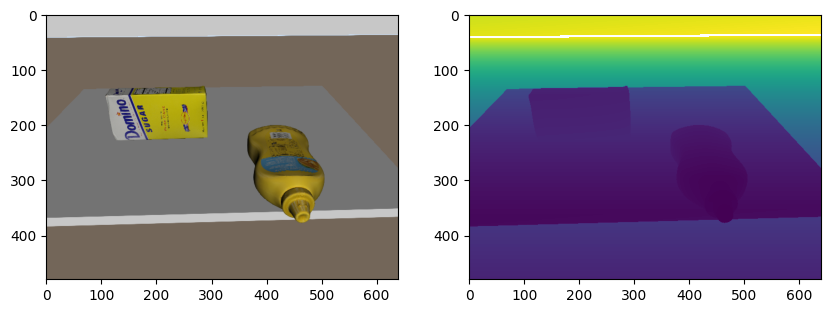

DEBUG:sponana.perception.banana_spotter_bayes3d:Displayed images.
INFO:sponana.perception.banana_spotter_bayes3d:Bayes3D init on table 0
DEBUG:sponana.perception.bayes3d.bayes3d_interface:In bayes3d_init.
DEBUG:sponana.perception.bayes3d.bayes3d_interface:Got table pose.
DEBUG:sponana.perception.bayes3d.bayes3d_interface:Got RGBD. scaling_factor=0.2.  table_pose_in_cam_frame=[[ 3.9102819e-02  9.9923509e-01  3.2923173e-09 -3.6825418e-02]
 [ 4.9961758e-01 -1.9551409e-02 -8.6602539e-01 -3.3310458e-02]
 [-8.6536306e-01  3.3864036e-02 -5.0000006e-01  6.3419539e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
DEBUG:sponana.perception.bayes3d._bayes3d:rgbd scaled down
DEBUG:sponana.perception.bayes3d._bayes3d:rgbd.scaeld_down intrinsics: Intrinsics(height=96, width=128, fx=115.88225099390857, fy=115.88225099390857, cx=63.900000000000006, cy=47.900000000000006, near=0.001, far=10000.0)
DEBUG:sponana.perception.bayes3d._bayes3d:setup clouds
DEBUG:sponana.perception.bayes3d._

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/
Fitting object 0...
Fitting object 1...


DEBUG:sponana.perception.bayes3d.bayes3d_interface:init inference complete
DEBUG:sponana.perception.bayes3d.bayes3d_interface:Meshcat display done.


Fitting object 2...


INFO:root:Score with target object: 18.658447265625
DEBUG:sponana.perception.bayes3d.bayes3d_interface:Attempted to fit target.
DEBUG:sponana.perception.bayes3d.bayes3d_interface:--> + showed meshcat
DEBUG:sponana.perception.bayes3d.bayes3d_interface:Computed possible target poses.
DEBUG:sponana.perception.bayes3d.bayes3d_interface:Conducted conversions.
INFO:sponana.perception.banana_spotter_bayes3d:--> known pose types: ['sugar_box', 'mustard_bottle'] | + 46 possible banana poses
INFO:sponana.perception.banana_spotter_bayes3d:Set perception_completed to true
INFO:sponana.fsm.finite_state_machine:--> Perception completed.
INFO:sponana.fsm.finite_state_machine:----> Banana not visible.
INFO:sponana.planner.navigator:Generating path from [ 1.00743376  3.99796953 -3.16926237] to [-0.69670947  3.15240161  0.8578673 ]
INFO:sponana.perception.banana_spotter_bayes3d:Currently at table 0.
INFO:sponana.perception.banana_spotter_bayes3d:Got images.


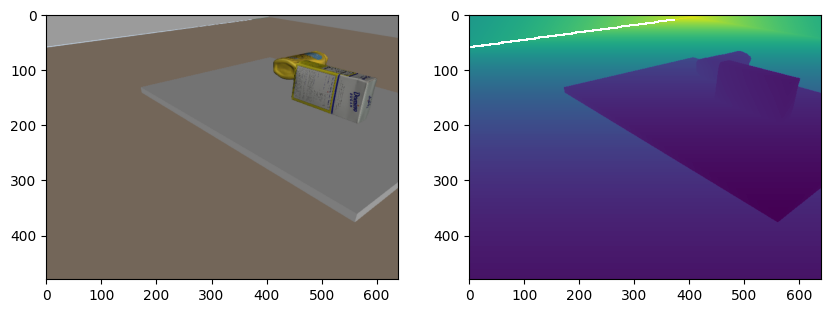

DEBUG:sponana.perception.banana_spotter_bayes3d:Displayed images.
INFO:sponana.perception.banana_spotter_bayes3d:Bayes3D update on table 0
DEBUG:sponana.perception.bayes3d._bayes3d:rgbd scaled down
DEBUG:sponana.perception.bayes3d._bayes3d:rgbd.scaeld_down intrinsics: Intrinsics(height=96, width=128, fx=115.88225099390857, fy=115.88225099390857, cx=63.900000000000006, cy=47.900000000000006, near=0.001, far=10000.0)
DEBUG:sponana.perception.bayes3d._bayes3d:setup clouds
DEBUG:sponana.perception.bayes3d._bayes3d:getting inliers
DEBUG:sponana.perception.bayes3d._bayes3d:updating table pose
DEBUG:sponana.perception.bayes3d._bayes3d:about to unproject depth
DEBUG:sponana.perception.bayes3d._bayes3d:depth unprojected


Target object is not visible.
Score without any rendered objects: 13.069662094116211
Max score with target object: 13.069662094116211


INFO:sponana.perception.banana_spotter_bayes3d:--> known pose types: ['sugar_box', 'mustard_bottle'] | + 1 possible banana poses
INFO:sponana.perception.banana_spotter_bayes3d:Set perception_completed to true
INFO:sponana.fsm.finite_state_machine:--> Perception completed.
INFO:sponana.fsm.finite_state_machine:----> Banana not visible.
INFO:sponana.planner.navigator:Generating path from [-0.83126796  3.19132466  0.8881998 ] to [-0.60371995  4.85234302 -0.96395409]
INFO:sponana.perception.banana_spotter_bayes3d:Currently at table 0.
INFO:sponana.perception.banana_spotter_bayes3d:Got images.


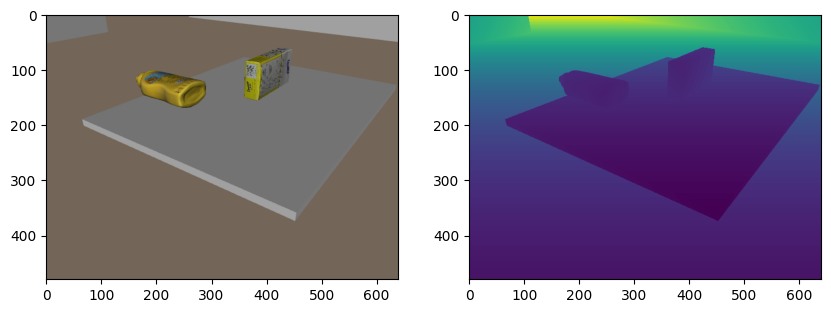

DEBUG:sponana.perception.banana_spotter_bayes3d:Displayed images.
INFO:sponana.perception.banana_spotter_bayes3d:Bayes3D update on table 0
DEBUG:sponana.perception.bayes3d._bayes3d:rgbd scaled down
DEBUG:sponana.perception.bayes3d._bayes3d:rgbd.scaeld_down intrinsics: Intrinsics(height=96, width=128, fx=115.88225099390857, fy=115.88225099390857, cx=63.900000000000006, cy=47.900000000000006, near=0.001, far=10000.0)
DEBUG:sponana.perception.bayes3d._bayes3d:setup clouds
DEBUG:sponana.perception.bayes3d._bayes3d:getting inliers
DEBUG:sponana.perception.bayes3d._bayes3d:updating table pose
DEBUG:sponana.perception.bayes3d._bayes3d:about to unproject depth
DEBUG:sponana.perception.bayes3d._bayes3d:depth unprojected


Target object is not visible.
Score without any rendered objects: 13.857015609741211
Max score with target object: 13.728841781616211


INFO:sponana.perception.banana_spotter_bayes3d:--> known pose types: ['sugar_box', 'mustard_bottle'] | + 1 possible banana poses
INFO:sponana.perception.banana_spotter_bayes3d:Set perception_completed to true
INFO:sponana.fsm.finite_state_machine:--> Perception completed.
INFO:sponana.fsm.finite_state_machine:----> Banana not visible.
INFO:sponana.planner.navigator:Generating path from [-0.61594825  4.95781239 -0.94338356] to [ 1.00000000e+00  1.82786641e-12 -3.13316598e+00]
INFO:sponana.perception.banana_spotter_bayes3d:Currently at table 0.
INFO:sponana.perception.banana_spotter_bayes3d:Got images.


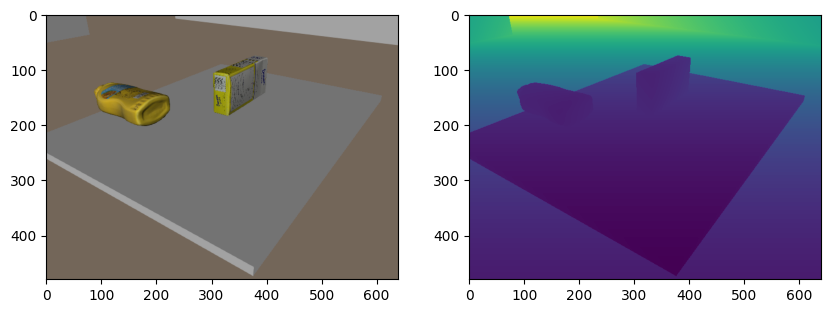

DEBUG:sponana.perception.banana_spotter_bayes3d:Displayed images.
INFO:sponana.perception.banana_spotter_bayes3d:Bayes3D update on table 0
DEBUG:sponana.perception.bayes3d._bayes3d:rgbd scaled down
DEBUG:sponana.perception.bayes3d._bayes3d:rgbd.scaeld_down intrinsics: Intrinsics(height=96, width=128, fx=115.88225099390857, fy=115.88225099390857, cx=63.900000000000006, cy=47.900000000000006, near=0.001, far=10000.0)
DEBUG:sponana.perception.bayes3d._bayes3d:setup clouds
DEBUG:sponana.perception.bayes3d._bayes3d:getting inliers
DEBUG:sponana.perception.bayes3d._bayes3d:updating table pose
DEBUG:sponana.perception.bayes3d._bayes3d:about to unproject depth
DEBUG:sponana.perception.bayes3d._bayes3d:depth unprojected
INFO:sponana.perception.banana_spotter_bayes3d:--> known pose types: ['sugar_box', 'mustard_bottle'] | + 1 possible banana poses
INFO:sponana.perception.banana_spotter_bayes3d:Set perception_completed to true
INFO:sponana.fsm.finite_state_machine:--> Perception completed.
INFO:s

Target object is not visible.
Score without any rendered objects: 17.502849578857422
Max score with target object: 17.364501953125


INFO:sponana.planner.navigator:Generating path from [-0.60688172  4.87816965 -0.95916429] to [-0.69670947 -0.84759839  0.8578673 ]
INFO:sponana.perception.banana_spotter_bayes3d:Currently at table 1.
INFO:sponana.perception.banana_spotter_bayes3d:Got images.


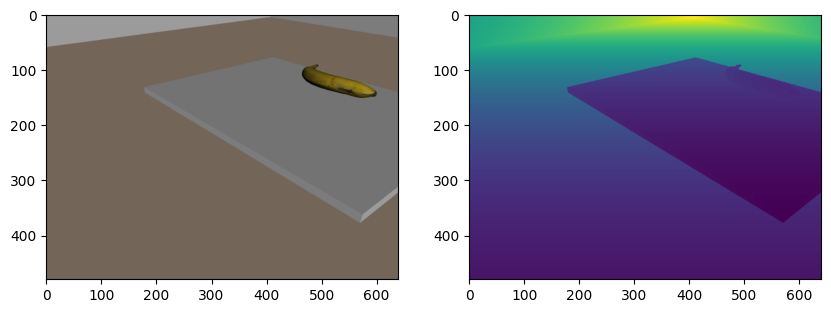

DEBUG:sponana.perception.banana_spotter_bayes3d:Displayed images.
INFO:sponana.perception.banana_spotter_bayes3d:Bayes3D init on table 1
DEBUG:sponana.perception.bayes3d.bayes3d_interface:In bayes3d_init.
DEBUG:sponana.perception.bayes3d.bayes3d_interface:Got table pose.
DEBUG:sponana.perception.bayes3d.bayes3d_interface:Got RGBD. scaling_factor=0.2.  table_pose_in_cam_frame=[[ 7.8236681e-01 -6.2281793e-01 -1.9641224e-09  1.8045397e-01]
 [-3.1140897e-01 -3.9118341e-01 -8.6602539e-01 -1.0975209e-01]
 [ 5.3937614e-01  6.7754954e-01 -5.0000000e-01  7.6659620e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
DEBUG:sponana.perception.bayes3d._bayes3d:rgbd scaled down
DEBUG:sponana.perception.bayes3d._bayes3d:rgbd.scaeld_down intrinsics: Intrinsics(height=96, width=128, fx=115.88225099390857, fy=115.88225099390857, cx=63.900000000000006, cy=47.900000000000006, near=0.001, far=10000.0)
DEBUG:sponana.perception.bayes3d._bayes3d:setup clouds
DEBUG:sponana.perception.bayes3d._

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
Fitting object 0...


INFO:root:Score with target object: 12.925211906433105
DEBUG:sponana.perception.bayes3d.bayes3d_interface:Attempted to fit target.
DEBUG:sponana.perception.bayes3d.bayes3d_interface:--> + showed meshcat
INFO:root:Target category banana found in scene.
DEBUG:sponana.perception.bayes3d.bayes3d_interface:Conducted conversions.
INFO:sponana.perception.banana_spotter_bayes3d:--> known pose types: ['banana'] | + 1 possible banana poses
INFO:sponana.perception.banana_spotter_bayes3d:---> Setting banana found = true.
INFO:sponana.perception.banana_spotter_bayes3d:---> Bayes3D banana pose: RigidTransform(
  R=RotationMatrix([
    [0.9271039962768555, -0.3748040497303009, 1.607466160180593e-08],
    [0.37480393052101135, 0.9271039366722107, 2.019254985441421e-08],
    [-2.9802322387695312e-08, -1.4901161193847656e-08, 1.0],
  ]),
  p=[0.15654951333999634, -0.0076427161693573, 0.22508499026298523],
)
INFO:sponana.perception.banana_spotter_bayes3d:---> Inferred Drake banana pose: RigidTransform(
 

Beginning grasp sequence.
{'initial': RigidTransform(
  R=RotationMatrix([
    [-0.0008962987412057398, 0.622430952328245, -0.7826742018441135],
    [-0.005354510500739635, 0.7826603089920379, 0.6224260357229483],
    [0.9999852628243399, 0.004748716904744478, 0.0026313156204856966],
  ]),
  p=[-0.5914936851174556, -0.4549951501702189, 0.7966796440014489],
), 'post_init': RigidTransform(
  R=RotationMatrix([
    [-0.0008962987412057398, 0.622430952328245, -0.7826742018441135],
    [-0.005354510500739635, 0.7826603089920379, 0.6224260357229483],
    [0.9999852628243399, 0.004748716904744478, 0.0026313156204856966],
  ]),
  p=[-0.6857854302534538, -0.25224391212642544, 0.7976807788160204],
), 'prepick': RigidTransform(
  R=RotationMatrix([
    [0.026881391704946706, 0.047527034506784874, -0.9985081731117659],
    [0.005944792036023407, 0.9988438706260401, 0.04770305609118695],
    [0.9996209532756172, -0.007218247971729347, 0.026567775002151905],
  ]),
  p=[0.1176386801377416, -0.3515286

In [9]:
rng = np.random.default_rng(145)  # this is for python
generator = RandomGenerator(rng.integers(0, 1000))  # this is for c++

logging.root.setLevel(logging.INFO)
# logging.root.setLevel(logging.DEBUG)  # Uncomment to enable debug logging.

fsm_logger = logging.getLogger("sponana.fsm")
fsm_logger.setLevel(logging.INFO)

bs_logger = logging.getLogger("sponana.perception")
bs_logger.setLevel(logging.DEBUG)

simulation_time = -1
# simulation_time = 1
add_debug_logger = True
add_fixed_cameras = False
use_teleop = False
plot_camera_input = True

simulator, diagram = sponana.sim.create_and_run_simulation(
    meshcat,
    rng,
    add_debug_logger=add_debug_logger,
    simulation_time=simulation_time,
    add_fixed_cameras=add_fixed_cameras,
    use_teleop=use_teleop,
    plot_camera_input=plot_camera_input,
    table_specs=specs
)

In [ ]:
# Check the camera on Spot
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("spot_camera.rgb_image").Eval(context)
depth_image = station.GetOutputPort("spot_camera.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

In [ ]:
# camera intrinsics
camera1 = station.GetSubsystemByName("rgbd_sensor_spot_camera")
camera_info = camera1.depth_camera_info()
print("intrinsics", camera_info.intrinsic_matrix())
print("focal length", camera_info.focal_x(), camera_info.focal_y())
print("field of view", camera_info.fov_x(), camera_info.fov_y())

In [ ]:
sponana.utils.visualize_diagram(diagram, max_depth=1)

In [ ]:
from sponana.hardcoded_cameras import get_base_positions_for_hardcoded_cameras

get_base_positions_for_hardcoded_cameras()

In [ ]:
get_base_positions_for_hardcoded_cameras().shape